# Test Notebook

In [1]:
import nest_asyncio
import asyncio
import schwabdev
from datetime import datetime, timedelta
from dotenv import load_dotenv
import time
import os
import json
import pandas as pd
import pytz
import numpy as np
import mplfinance as mpf
from IPython.display import display, clear_output
import warnings
from Multi_Strat_Back_Tester_Functions import *

Load environment variables from .env file

In [2]:
load_dotenv()

True

Patches the notebook's running event loop so that it can handle multiple calls to `asyncio.run()` or other asynchronous methods without causing conflicts

In [3]:
nest_asyncio.apply()

Set the display options

In [4]:
# Display options
# Set the global float format to 4 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

Create the client object.

In [5]:
app_key = os.getenv('app_key')
app_secret = os.getenv('app_secret')
callback_url = os.getenv('callback_url')

# Print them to verify (avoid printing sensitive info in production)
print(f"App Key: {app_key}")
print(f"App Secret: {app_secret}")
print(f"Callback URL: {callback_url}")

# Now proceed to initialize the client
client = schwabdev.Client(app_key, app_secret, callback_url)
print('Client initialized!')

App Key: 2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150
App Secret: OQGxH0GkD5bAEMA4
Callback URL: https://127.0.0.1
Client initialized!


Use this when in need of updating the refresh token.

In [6]:
# client.update_tokens(force=True)
# client = schwabdev.Client(app_key, app_secret, callback_url)

### Streamer Related Functions:

Helper function to extract row data from content

In [7]:
# tickers = "MARA,PLUG,SOFI,SWN,RKLB"
tickers = "/ES,/NQ"

# Here

In [8]:
def extract_row_data(entry, content):
    
    # Create a row dictionary with the relevant fields
    row = { # For futures
        'timestamp': entry['timestamp'],
        'key': content.get('key', None),
        'bid_price': content.get('1', None),
        'ask_price': content.get('2', None),
        # 'last_price': last_price,  # Use updated last_price
        'last_price': content.get('3', None),
        'bid_size': content.get('4', None), # These two variables can be correlated 
        'ask_size': content.get('5', None), # with direction of price action
        'total_volume': content.get('8', None),
        'last_size': content.get('9', 0),
        'high_price': content.get('12', None),
        'low_price': content.get('13', None),
        'close_price': content.get('14', None),
        'open_price': content.get('18', None),
        'net_change': content.get('19', None),
        'future_pct_change': content.get('20', None),
        'open_interest': content.get('23', None),
        'tick': content.get('25', None),
        'tick_amount': content.get('26', None),
        'future_exp_date': content.get('35', None),
        'ask_time': content.get('37', None),
        'bid_time': content.get('38', None)}

    # row = { # For equities
    #     'timestamp': entry['timestamp'],               # Same
    #     'key': content.get('key', None),               # Same
    #     'bid_price': content.get('1', None),           # Matches bid_price
    #     'ask_price': content.get('2', None),           # Matches ask_price
    #     'last_price': last_price,                      # Matches last_price (updated)
    #     'bid_size': content.get('4', None),            # Matches bid_size
    #     'ask_size': content.get('5', None),            # Matches ask_size
    #     'total_volume': content.get('8', None),        # Matches total_volume
    #     'last_size': content.get('9', 0),              # Matches last_size
    #     'high_price': content.get('10', None),         # Matches high_price
    #     'low_price': content.get('11', None),          # Matches low_price
    #     'close_price': content.get('12', None),        # Matches close_price
    #     'open_price': content.get('17', None),         # Matches open_price
    #     'net_change': content.get('18', None),         # Matches net_change
    #     '52_week_high': content.get('19', None),       # Matches 52_week_high
    #     '52_week_low': content.get('20', None),        # Matches 52_week_low
    #     'pe_ratio': content.get('21', None),           # Matches pe_ratio
    #     'net_pct_change': content.get('42', None)}      # Matches net_pct_change  
    
    return row


In [9]:
# Initialize a dictionary to store DataFrames for each ticker
ticker_tables = {ticker: pd.DataFrame() for ticker in tickers.split(",")}

# Initialize a dictionary to store the last known price for each ticker
last_known_price = {ticker: None for ticker in tickers.split(",")}

def process_message_data(data):
    global ticker_tables, last_known_price
    
    # Loop through the content and extract the relevant fields
    if "data" in data:
        for entry in data['data']:
            if 'content' in entry:
                for content in entry['content']:
                    # Extract row data
                    row = extract_row_data(entry, content)

                    # Get the ticker (key) and last_price
                    ticker = row['key']
                    last_price = row.get('last_price')

                    # Check if last_price is None, if so use the last known price for the ticker
                    if last_price is None and ticker in last_known_price:
                        row['last_price'] = last_known_price[ticker]
                    else:
                        # Update the last known price
                        last_known_price[ticker] = last_price

                    # Convert the row dictionary to a DataFrame
                    row_df = pd.DataFrame([row])

                    # Check the ticker and append the row to the correct ticker table
                    if ticker in ticker_tables:
                        ticker_tables[ticker] = pd.concat([ticker_tables[ticker], row_df], ignore_index=True)

In [10]:
# Initialize the minute_candles dictionary globally
minute_candles = {ticker: pd.DataFrame(columns=['datetime', 'ticker', 'open', 'high', 'low', 'close', 'accumulative_volume']) for ticker in tickers.split(",")}

def update_minute_candles(ticker_tables):
    global minute_candles

    for ticker, df in ticker_tables.items():
        if df.empty:
            continue
        
        # Ensure that 'datetime' column exists and is properly set
        if 'timestamp' in df.columns:
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('US/Eastern')

        # Ensure that the 'datetime' column is set as the DataFrame index (only if not already set)
        if df.index.name != 'datetime':
            df.set_index('datetime', inplace=True)

        # Group the data by minute intervals using 'min'
        current_minute = df.index.floor('min')[-1]  # Get the most recent minute

        # Select only the rows from the most recent minute
        recent_data = df[df.index.floor('min') == current_minute]

        if not recent_data.empty:
            # Extract OHLC values for the minute candle
            open_price = recent_data['last_price'].iloc[0]  # Open is the first last_price
            high_price = recent_data['last_price'].max()     # High is the max last_price
            low_price = recent_data['last_price'].min()      # Low is the min last_price
            close_price = recent_data['last_price'].iloc[-1] # Close is the last last_price
            total_volume = recent_data['total_volume'].max() # Total volume is the max value in this interval

            # Create a dictionary with the new candle data
            new_candle = {
                'datetime': current_minute,
                'ticker': ticker,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'accumulative_volume': total_volume
            }

            # Convert the dictionary to a DataFrame and update the respective ticker's DataFrame in minute_candles
            new_candle_df = pd.DataFrame([new_candle])

            # Replace or append the most recent candle for this ticker
            if not minute_candles[ticker].empty and minute_candles[ticker]['datetime'].iloc[-1] == current_minute:
                minute_candles[ticker].iloc[-1] = new_candle  # Update the last candle
            else:
                minute_candles[ticker] = pd.concat([minute_candles[ticker], new_candle_df], ignore_index=True)  # Append new candle


In [11]:
def calculate_indicators(df, price_col='close', acc_vol_col='accumulative_volume', sma_periods=None, wma_periods=None, rsi_periods=None, volume_col='volume'):
    """
    Calculate SMAs and WMAs for given periods and append them to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the price data.
    price_col (str): The column name for the price data (default 'close').
    acc_vol_col (str): The column name for the accumulative volume data (default 'accumulative_volume').
    sma_periods (list): A list of periods for SMAs (e.g., [3, 5, 10, 20]).
    wma_periods (list): A list of periods for WMAs (e.g., [3, 5, 10, 20]).
    volume_col (str): The column name to store the volume difference (default 'volume').
    
    Returns:
    pd.DataFrame: The DataFrame with the calculated SMAs and WMAs appended.
    """
    # Calculate volume differences
    df[volume_col] = df[acc_vol_col].diff()
    
    # Calculate SMAs
    if sma_periods:
        for period in sma_periods:
            sma_col_name = f'sma_{period}'
            df[sma_col_name] = df[price_col].rolling(window=period).mean()
    
    # Calculate WMAs
    if wma_periods:
        for period in wma_periods:
            weights = np.arange(1, period + 1)  # Generate weights from 1 to the period length
            wma_col_name = f'wma_{period}'
            df[wma_col_name] = df[price_col].rolling(window=period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

    # calculate_vwap_and_bands(df, high_col='high', low_col='low', close_col='close', volume_col='volume')

    # Assume 'periods' is a predefined list of different periods for which you want to calculate RSI
    for period in rsi_periods:
        # Calculate RSI for each period
        delta = df[price_col].diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
        rs = gain / loss
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))

    return df

In [12]:
def check_moving_average(candles, ma_name1='wma_5', ma_name2='sma_5', rsi_column='rsi_5'):
    """
    Function to check if the moving average is above or below another moving average for each row.
    
    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data.
    - ma_name1 (str): The column name for the first moving average (default is 'wma_5').
    - ma_name2 (str): The column name for the second moving average (default is 'sma_5').
    
    Returns:
    - candles (pd.DataFrame): The DataFrame with an updated 'signal' column.
    """
    current_time_USE = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d %H:%M:%S')
    current_hour = datetime.now(pytz.timezone('US/Eastern')).hour    
    current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
    current_second = datetime.now(pytz.timezone('US/Eastern')).second

    # Check if the moving average and RSI columns exist and have valid data
    if ma_name1 in candles.columns and ma_name2 in candles.columns:
        
        # Iterate through each row to compare the values of 'wma_5', 'sma_5'
        for i, row in candles.iterrows():
            # Check moving average condition
            if pd.notna(row[ma_name1]) and pd.notna(row[ma_name2]):
                if row[ma_name1] > row[ma_name2]:
                    candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 1  # wma_5 is above sma_5
                    # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is ABOVE {ma_name2} {row[ma_name2]}, long entry")
                elif row[ma_name1] < row[ma_name2]:
                    candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # wma_5 is below sma_5
                    # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is BELOW {ma_name2} {row[ma_name2]}, long exit")
                else:
                    candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # wma_5 is equal to sma_5
                    # print(f"{current_time_USE}: {ma_name1} {row[ma_name1]} is EQUAL to {ma_name2} {row[ma_name2]}, no signal")
            else:
                candles.at[i, f'signal_{ma_name1}_{ma_name2}'] = 0  # If any data is missing, set signal to 0
                # print(f"{current_time_USE}: Insufficient data for {ma_name2} or {ma_name1} for index {i}")

    else:
        # If columns are missing, set the whole column to 0 (no signal)
        print(f"{current_time_USE}: Either {ma_name1} or {ma_name2} do not exist in {candles}")                

    if rsi_column in candles.columns:
            
        for i, row in candles.iterrows():    

            # Generate signals based on RSI
            if pd.notna(row[rsi_column]):
                if row[rsi_column] > 50:
                    candles.at[i, f'signal_{rsi_column}'] = 1  # RSI above 50
                    # print(f"{current_time_USE}: RSI {row[rsi_column]} is ABOVE 50, long entry")
                elif row[rsi_column] < 50:
                    candles.at[i, f'signal_{rsi_column}'] = 0  # RSI below 50
                    # print(f"{current_time_USE}: RSI {row[rsi_column]} is BELOW 50, long exit")
                elif row[rsi_column] == 50:
                    candles.at[i, f'signal_{rsi_column}'] = 0  # RSI at 50
                    # print(f"{current_time_USE}: RSI {row[rsi_column]} is EQUAL to 50, no signal")
            else:
                candles.at[i, f'signal_{rsi_column}'] = 0  # Handle missing data for RSI
                # print(f"{current_time_USE}: Insufficient data for {rsi_column} at index {i}")

    else:
        # If columns are missing, set the whole column to 0 (no signal)
        print(f"{current_time_USE}: {rsi_column} does not exist in {candles}")

    return candles

In [13]:
def calculate_profit_loss(candles, signal_ma='signal_wma_5_sma_5', signal_rsi='signal_rsi_5', multiplier=50): # multiplier=?? for stocks, multiplier=50 for ES
    """
    Function to calculate profit and loss based on the buy/sell signals and price movement.
    Assumes you're buying one share at a time and selling it to exit. No short selling.
    
    Parameters:
    - candles (pd.DataFrame): The DataFrame containing candle data and signal columns.

    Returns:
    - candles (pd.DataFrame): The DataFrame with 'pnl_ma' and 'pnl_rsi' columns showing profit/loss for each trade.
    """
    
    # Add columns to store profit/loss for each strategy
    candles['pnl_ma'] = None
    candles['pnl_rsi'] = None
    
    ma_position_open = False
    rsi_position_open = False
    
    ma_buy_price = None
    rsi_buy_price = None
    
    for i, row in candles.iterrows():
        # Moving Average Strategy
        if row[signal_ma] == 1 and not ma_position_open:
            # Buy condition for MA
            ma_buy_price = row['close']
            ma_position_open = True
            candles.at[i, 'pnl_ma'] = 0  # No PnL on the buy
            # print(f"MA Buy at {ma_buy_price}")
            
        elif row[signal_ma] == 0 and ma_position_open:
            # Sell condition for MA (exit position)
            ma_sell_price = row['close']
            ma_position_open = False
            # Calculate profit
            candles.at[i, 'pnl_ma'] = (ma_sell_price - ma_buy_price)*multiplier
            # print(f"MA Sell at {ma_sell_price}, PnL: {ma_sell_price - ma_buy_price}")
            
        # RSI Strategy
        if row[signal_rsi] == 1 and not rsi_position_open:
            # Buy condition for RSI
            rsi_buy_price = row['close']
            rsi_position_open = True
            candles.at[i, 'pnl_rsi'] = 0  # No PnL on the buy
            # print(f"RSI Buy at {rsi_buy_price}")
            
        elif row[signal_rsi] == 0 and rsi_position_open:
            # Sell condition for RSI (exit position)
            rsi_sell_price = row['close']
            rsi_position_open = False
            # Calculate profit
            candles.at[i, 'pnl_rsi'] = (rsi_sell_price - rsi_buy_price)*multiplier
            # print(f"RSI Sell at {rsi_sell_price}, PnL: {rsi_sell_price - rsi_buy_price}")
    
    # Replace any NaN values with 0 (if no trade happened on that row)
    candles['pnl_ma'].fillna(0, inplace=True)
    candles['pnl_rsi'].fillna(0, inplace=True)
    
    return candles

In [14]:
def plot_moving_averages(df, ma1='wma_5', ma2='sma_5', rsi_plt='rsi_5', signal_column='signal_wma_5_sma_5', signal_column_2='signal_rsi_5', 
                         figsize=(30, 20), ma_markersize=50, signal_markersize_y=600, signal_markersize_b=500, v_if_short='o'): #'v' if short enabled, 'o' if not
    """
    Plots the minute_candles DataFrame with two selected moving averages and optional RSI.
    Also plots cumulative profit for MA and RSI strategies on a secondary axis.

    Parameters:
    - ma1 (str): The column name of the first moving average to plot.
    - ma2 (str): The column name of the second moving average to plot.
    - signal_column (str): The column name of the signal data (default is 'signal').
    - figsize (tuple): The size of the plot (width, height) in inches (default is (30, 20)).
    """

    df['hundred_line'] = 100
    df['fifty_line'] = 50  # Add a zero line for the RSI panel
    df['zero_line'] = 0

    # Ensure the required columns exist
    if ma1 not in df.columns or ma2 not in df.columns or rsi_plt not in df.columns:
        raise ValueError("Invalid column names provided for moving averages or RSI.")

    # Calculate cumulative profit
    if 'pnl_ma' in df.columns and 'pnl_rsi' in df.columns:
        df['cum_pnl_ma'] = df['pnl_ma'].cumsum()
        df['cum_pnl_rsi'] = df['pnl_rsi'].cumsum()
        df['cum_pnl_all'] = df['cum_pnl_ma'] + df['cum_pnl_rsi']
    else:
        raise ValueError("Missing 'pnl_ma' or 'pnl_rsi' columns for cumulative profit plotting.")

    # Clean the data to ensure numeric columns are valid
    columns_to_convert = ['open', 'high', 'low', 'close', 'volume', ma1, ma2, rsi_plt]
    df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

    # Select the columns to plot
    plot_data = df[['datetime', 'open', 'high', 'low', 'close', 'volume', ma1, ma2, rsi_plt]].copy()
    plot_data.set_index('datetime', inplace=True)

    # Create the additional plots for the moving averages and RSI, but only if they are warmed up
    add_plots = []

    # Check if the moving averages have enough valid data to plot
    if not df[ma1].isnull().all() and not df[ma2].isnull().all():
        add_plots.append(mpf.make_addplot(plot_data[ma1], color='magenta', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma1}'))
        add_plots.append(mpf.make_addplot(plot_data[ma1], color='magenta', linestyle='-', width=0.75))
        add_plots.append(mpf.make_addplot(plot_data[ma2], color='cyan', type='scatter', marker='o', markersize=ma_markersize, label=f'{ma2}'))
        add_plots.append(mpf.make_addplot(plot_data[ma2], color='cyan', linestyle='-', width=0.75))
    else:
        print("Moving averages have not warmed up yet. Plotting without them.")

    # Check if the RSI has enough valid data to plot
    if not df[rsi_plt].isnull().all():
        add_plots.append(mpf.make_addplot(df[rsi_plt], panel=2, color='blue', type='scatter', marker='o', markersize=ma_markersize, label='RSI'))
        add_plots.append(mpf.make_addplot(df[rsi_plt], panel=2, color='blue', linestyle='-', width=0.75))
        add_plots.append(mpf.make_addplot(df['hundred_line'], panel=2, color='red', linestyle=':', secondary_y=False))
        add_plots.append(mpf.make_addplot(df['fifty_line'], panel=2, color='yellow', linestyle=':', secondary_y=False))
        add_plots.append(mpf.make_addplot(df['zero_line'], panel=2, color='green', linestyle=':', secondary_y=False))
    else:
        print("RSI has not warmed up yet. Plotting without it.")

    # Add buy, sell, and neutral markers if signal_column exists
    if signal_column:
        df = add_signal_markers(df, signal_column, price_col='close')
        add_plots.append(mpf.make_addplot(df['buy_marker'], type='scatter', marker='^', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
        add_plots.append(mpf.make_addplot(df['sell_marker'], type='scatter', marker=v_if_short, markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))
        add_plots.append(mpf.make_addplot(df['neutral_marker'], type='scatter', marker='o', markersize=signal_markersize_y, color='yellow', panel=0, secondary_y=False))

    if signal_column_2:
        df = add_signal_markers(df, signal_column_2, price_col='close', buy_marker='buy_marker_2', sell_marker='sell_marker_2', neutral_marker='neutral_marker_2')
        add_plots.append(mpf.make_addplot(df['buy_marker_2'], type='scatter', marker='^', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
        add_plots.append(mpf.make_addplot(df['sell_marker_2'], type='scatter', marker=v_if_short, markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))
        add_plots.append(mpf.make_addplot(df['neutral_marker_2'], type='scatter', marker='o', markersize=signal_markersize_b, color='blue', panel=0, secondary_y=False))

    # Add cumulative profit plots on a secondary y-axis
    add_plots.append(mpf.make_addplot(df['cum_pnl_ma'], panel=0, color='yellow', secondary_y=True, label='Cumulative PnL (MA)', linestyle='-', width=1))
    add_plots.append(mpf.make_addplot(df['cum_pnl_rsi'], panel=0, color='blue', secondary_y=True, label='Cumulative PnL (RSI)', linestyle='-', width=1))
    add_plots.append(mpf.make_addplot(df['cum_pnl_all'], panel=0, color='green', secondary_y=True, label='Cumulative PnL (Combined)', linestyle='-', width=1))

    # Create a custom style with a black background
    black_style = mpf.make_mpf_style(
        base_mpf_style='charles',  # Start with the 'charles' style and modify it
        facecolor='black',         # Set the background color to black
        gridcolor='black',          # Set the grid line color
        edgecolor='purple',          # Set the edge color for candles and boxes
        figcolor='black',          # Set the figure background color to black
        rc={'axes.labelcolor': 'yellow', 'xtick.color': 'yellow', 'ytick.color': 'yellow', 'axes.titlecolor': 'yellow'}  # Set tick and label colors to white
    )

    # Plot using mplfinance
    mpf.plot(plot_data, type='candle', style=black_style, 
             title='',
             ylabel='Price', 
             addplot=add_plots, 
             figsize=figsize,
             volume=True,
            #  panel_ratios=(8, 2, 2),             
             tight_layout=True)

In [28]:
def visualize_trades():
    # Iterate through both dictionaries without a function
    for (ticker, minute_candles_df), (ticker_table_key, ticker_table_df) in zip(minute_candles.items(), ticker_tables.items()):    
        # Create a copy of the minute_candles DataFrame
        minute_candles_viz = minute_candles_df.copy()
        # Calculate profit/loss for each DataFrame
        calculate_profit_loss(minute_candles_viz, signal_ma=signal_ma, signal_rsi=signal_rsi, multiplier=50)
        try:
            # Plot moving averages
            plot_moving_averages(minute_candles_viz, sig_ma, con_ma, rsi_plt, signal_column='signal_wma_5_sma_5', 
                                signal_column_2='signal_rsi_5', figsize=(30, 20), 
                                ma_markersize=50, signal_markersize_y=450, signal_markersize_b=300, v_if_short='o') 
            # Display the DataFrames after the plot attempt
            display(minute_candles_viz)
            # display(ticker_table_df)  # Display the corresponding ticker_table
        except Exception as e:
            print(f"Error during plotting: {e}")
            # Display the DataFrames even if plotting fails
            display(minute_candles_viz)
            # display(ticker_table_df)

In [16]:
# # Scratchpad for figuring out the multiplier for markersizes

# result = 2 ** 3  # 2 raised to the power of 3
# print(result)  # Output: 8

# result = pow(2, 3)  # 2 raised to the power of 3
# print(result)  # Output: 8

# import math

# result = math.pow(2, 3)  # 2 raised to the power of 3
# print(result)  # Output: 8.0

# # 1 2 3 4 5 6 7 8 9
# # - - - - - - - - -
# # 9 9 9 9 9 9 9 9 9

# len(minute_candles)/2

In [17]:
linked_accounts = client.account_linked().json()
linked_accounts

account_hash = linked_accounts[0].get('hashValue')
print(account_hash)

equity_ticker = 'MARA'
futures_ticker = '/ES'

buy_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "BUY",
                "quantity": 1,
                "instrument": {
                    "symbol": equity_ticker,
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

sell_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "SELL",
                "quantity": 1,
                "instrument": {
                    "symbol": equity_ticker,
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

8C2363FAEB6002C9B8323540563E17BD7076A5C19E1F2C524AD4B43649C726A7


In [18]:
# Initialize a variable to track if a position is open (market neutral) for function `trade_logic`
position_open = False  # False means market neutral, True means a trade is active
entry_price = None  # Store the entry price when a trade is opened

# Initialize a variable to track if a position is open (market neutral) for function `trade_logic`
sim_position_open = False  # False means market neutral, True means a trade is active
sim_entry_price = None  # Store the entry price when a trade is opened

In [19]:
# def trade_logic(candles, buy_order=None, sell_order=None):
#     """
#     Function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.
#     - buy_order (dict): The buy order configuration (market order).
#     - sell_order (dict): The sell order configuration (market order).
#     """

#     global position_open, entry_price  # Ensure access to global variables

#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Check if it's the start of a new minute (second == 00)
#     if current_second == 0 or 1:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         previous_signal = candles.iloc[-2]['signal']

#         if previous_signal == 1:
#             # If signal is 1 and no position is open, go long (buy)
#             if not position_open:
#                 # Place buy order
#                 resp = client.order_place(account_hash, buy_order)
#                 print(f"Buy order placed. Response: {resp}")
                
#                 # Mark position as open and record entry price
#                 position_open = True
#                 entry_price = candles.iloc[-2]['close']
#                 print(f"Bought at {entry_price}")
#             else:
#                 print("Position already open, no action taken.")

#         elif previous_signal == 0 or previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, close the position (sell)
#             if position_open:
#                 # Place sell order
#                 resp = client.order_place(account_hash, sell_order)
#                 print(f"Sell order placed. Response: {resp}")
                
#                 # Close position
#                 position_open = False
#                 print(f"Sold at {candles.iloc[-2]['close']}")
#             else:
#                 print("No position open, no action taken.")

# def trade_simulator(candles):
#     """
#     Simulated function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.

#     The function updates the 'sim_signal', 'sim_entry', and 'sim_exit' columns in the DataFrame.
#     """

#     global sim_position_open, sim_entry_price  # Ensure access to global variables

#     # Initialize the new columns if they don't exist
#     if 'sim_signal' not in candles.columns:
#         candles['sim_signal'] = None
#     if 'sim_entry' not in candles.columns:
#         candles['sim_entry'] = None
#     if 'sim_exit' not in candles.columns:
#         candles['sim_exit'] = None

#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Check if it's the start of a new minute (second == 00)
#     if current_second == 0 or 1:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         sim_previous_signal = candles.iloc[-2]['signal']

#         if sim_previous_signal == 1:
#             # If signal is 1 and no position is open, simulate going long (buy)
#             if not sim_position_open:
#                 # Simulate buy entry
#                 sim_entry_price = candles.iloc[-2]['close']
#                 sim_position_open = True
                
#                 # Record simulated signal and entry price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = 1
#                 candles.at[candles.index[-2], 'sim_entry'] = sim_entry_price

#                 print(f"Simulated buy at {sim_entry_price}")

#             else:
#                 print("Position already open, no action taken.")

#         elif sim_previous_signal == 0 or sim_previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, simulate closing the position (sell)
#             if sim_position_open:
#                 # Simulate sell exit
#                 sim_exit_price = candles.iloc[-2]['close']
#                 sim_position_open = False

#                 # Record simulated signal and exit price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = -1
#                 candles.at[candles.index[-2], 'sim_exit'] = sim_exit_price

#                 print(f"Simulated sell at {sim_exit_price}")
#             else:
#                 print("No position open, no action taken.")

# def trade_simulator(candles):
#     """
#     Simulated function to decide whether to go long or close positions based on the signal column.

#     Parameters:
#     - candles (pd.DataFrame): The DataFrame containing minute candle data.

#     The function updates the 'sim_signal' and 'sim_price' columns in the DataFrame.
#     """

#     global sim_position_open, sim_entry_price  # Ensure access to global variables

#     current_time = datetime.now(pytz.timezone('US/Eastern'))
#     current_hour = datetime.now(pytz.timezone('US/Eastern')).hour    
#     current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
#     current_second = datetime.now(pytz.timezone('US/Eastern')).second

#     # Initialize the new columns if they don't exist
#     if 'sim_signal' not in candles.columns:
#         candles['sim_signal'] = None
#     if 'sim_price' not in candles.columns:
#         candles['sim_price'] = None

#     # Check if it's the start of a new minute (second == 00)
#     if current_time.second == 0:
#         # Ensure there is enough data in candles (at least 2 rows to check the previous signal)
#         if len(candles) < 2:
#             print("Not enough data to make a trade decision.")
#             return

#         # Get the signal from the row before the one currently forming
#         sim_previous_signal = candles.iloc[-2]['signal']

#         if sim_previous_signal == 1:
#             # If signal is 1 and no position is open, simulate going long (buy)
#             if not sim_position_open:
#                 # Simulate buy entry
#                 sim_entry_price = candles.iloc[-2]['close']
#                 sim_position_open = True
                
#                 # Record simulated signal and entry price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = 1
#                 candles.at[candles.index[-2], 'sim_price'] = sim_entry_price

#                 print(f"Simulated buy at {sim_entry_price}")

#             else:
#                 print("Position already open, no action taken.")

#         elif sim_previous_signal == 0 or sim_previous_signal == -1:
#             # If signal is 0 or -1 and a position is open, simulate closing the position (sell)
#             if sim_position_open:
#                 # Simulate sell exit
#                 sim_exit_price = candles.iloc[-2]['close']
#                 sim_position_open = False

#                 # Record simulated signal and exit price in the DataFrame
#                 candles.at[candles.index[-2], 'sim_signal'] = -1
#                 candles.at[candles.index[-2], 'sim_price'] = sim_exit_price

#                 print(f"Simulated sell at {sim_exit_price}")
#             else:
#                 print("No position open, no action taken.")

### The Data Handler:

In [20]:
# Define the periods for SMAs and WMAs
ma_periods=[5, 10, 20]

# Initialize a variable to track the last known last_price for `extract_row_data` function
previous_last_price = None

todays_price_action = pd.DataFrame(columns=['timestamp', # For futures
                                            'key', 
                                            'bid_price', 
                                            'ask_price', 
                                            'last_price', 
                                            'bid_size', 
                                            'ask_size', 
                                            'total_volume', 
                                            'last_size', 
                                            'high_price', 
                                            'low_price', 
                                            'close_price', 
                                            'open_price', 
                                            'net_change', 
                                            'future_pct_change', 
                                            'open_interest', 
                                            'tick', 
                                            'tick_amount', 
                                            'future_exp_date', 
                                            'ask_time', 
                                            'bid_time'])

# todays_price_action = pd.DataFrame(columns=['timestamp', # For equities
#                                             'key', #0
#                                             'bid_price', #1
#                                             'ask_price', #2
#                                             'last_price', #3
#                                             'bid_size', #4
#                                             'ask_size', #5
#                                             'total_volume', #8
#                                             'last_size', #9
#                                             'high_price', #10
#                                             'low_price', #11
#                                             'close_price', #12
#                                             'open_price', #17
#                                             'net_change', #18
#                                             '52_week_high', #19
#                                             '52_week_low', #20
#                                             'pe_ratio', #21
#                                             'net_pct_change', #42
#                                             ])

Function to handle and process incoming data

In [21]:
def handle_data(message):
    global minute_candles

    sma_periods = ma_periods
    wma_periods = ma_periods
    rsi_periods = ma_periods

    current_hour = datetime.now(pytz.timezone('US/Eastern')).hour
    current_minute = datetime.now(pytz.timezone('US/Eastern')).minute
    current_second = datetime.now(pytz.timezone('US/Eastern')).second

    # Define the list of (sig_ma, con_ma, rsi_col) combinations
    ma_combinations = [
        ('wma_5', 'sma_5', 'rsi_5'),
        ('wma_10', 'sma_10', 'rsi_10'),
        ('wma_20', 'sma_20', 'rsi_20')
    ]

    # Try parsing the incoming message
    try:
        data = json.loads(message)

        # Call the function to process the data and update todays_price_action
        process_message_data(data)

        # **Update the minute candles in real-time**
        update_minute_candles(ticker_tables)

        # Iterate through all the tickers in ticker_tables
        for ticker, df in minute_candles.items():
            # Calculate moving averages and indicators for each DataFrame
            minute_candles[ticker] = calculate_indicators(
                df, 
                price_col='close', 
                acc_vol_col='accumulative_volume', 
                sma_periods=sma_periods, 
                wma_periods=wma_periods,
                rsi_periods=rsi_periods
            )

        # Iterate through all the tickers in minute_candles dictionary
        for ticker, df in minute_candles.items():
            # Iterate over the (sig_ma, con_ma, rsi_col) combinations for each ticker
            for sig_ma, con_ma, rsi_col in ma_combinations:                                    # CHANGE THE SIMULATED STRATEGY HERE
                # Call the check_moving_average function for each combination
                check_moving_average(df, ma_name1=sig_ma, ma_name2=con_ma, rsi_column=rsi_col) # CHANGE THE SIMULATED STRATEGY HERE

        # if current_second == 59 or 00 or 1 or 2:
        #     # Call the trade_logic function to execute trades based on the signal
        #     trade_logic(minute_candles, buy_order=buy_order, sell_order=sell_order)

        # if current_second == 59 or 00 or 1 or 2:
        #     # Call the trade_simulator function to simulate trades based on the signal
        #     trade_simulator(minute_candles)

        # print(message)

    except Exception as e:
        print(f"Error processing message: {e}")


In [22]:
streamer = client.stream

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
# Start the streamer and send the level one futures subscription
streamer.start(handle_data)
streamer.send(streamer.level_one_futures(tickers, "0,1,2,3,4,5,8,9,12,13,14,18,19,20,23,25,26,35,37,38")) # For futures
# streamer.send(streamer.level_one_equities(tickers, "0,1,2,3,4,5,8,9,10,11,12,17,18,19,20,21,42")) # For equities
# time.sleep(20)

Stop the streamer

In [25]:
streamer.stop(clear_subscriptions=True)

In [ ]:
tickers_list = list(ticker_tables.keys())
display(ticker_tables[tickers_list[0]])
display(minute_candles[tickers_list[0]])
# minute_candles[tickers_list[1]]

- __Think about the following:__
- Using higher highs and lower lows to determine the trend
- Switching between doing nothing and trading the strategy based on higher highs/lows and lower highs/lows
- 0 and 100 RSI levels to intervene in the strategy when taking profit or entering a trade
- Think about running simultaneous strategies on different timeframes or using different indicators
- Write code to aggregate profit/loss and trade statistics
- Mostly finding alpha (can we do so by simulation or backtesting)
- Move towards larger timeframes
- Learn more about trading futures on Schwab
- Try and approximate the perfect second derivative work
- Make a simulation version of this where indicators and signals are created outside of the data handler. Hopefully can run two notebooks at the same time
- Find a way to make this all work trading both long and short trades
- Write data directly to cloud or json and call it back for visualization

Visualize the streamed and stored data

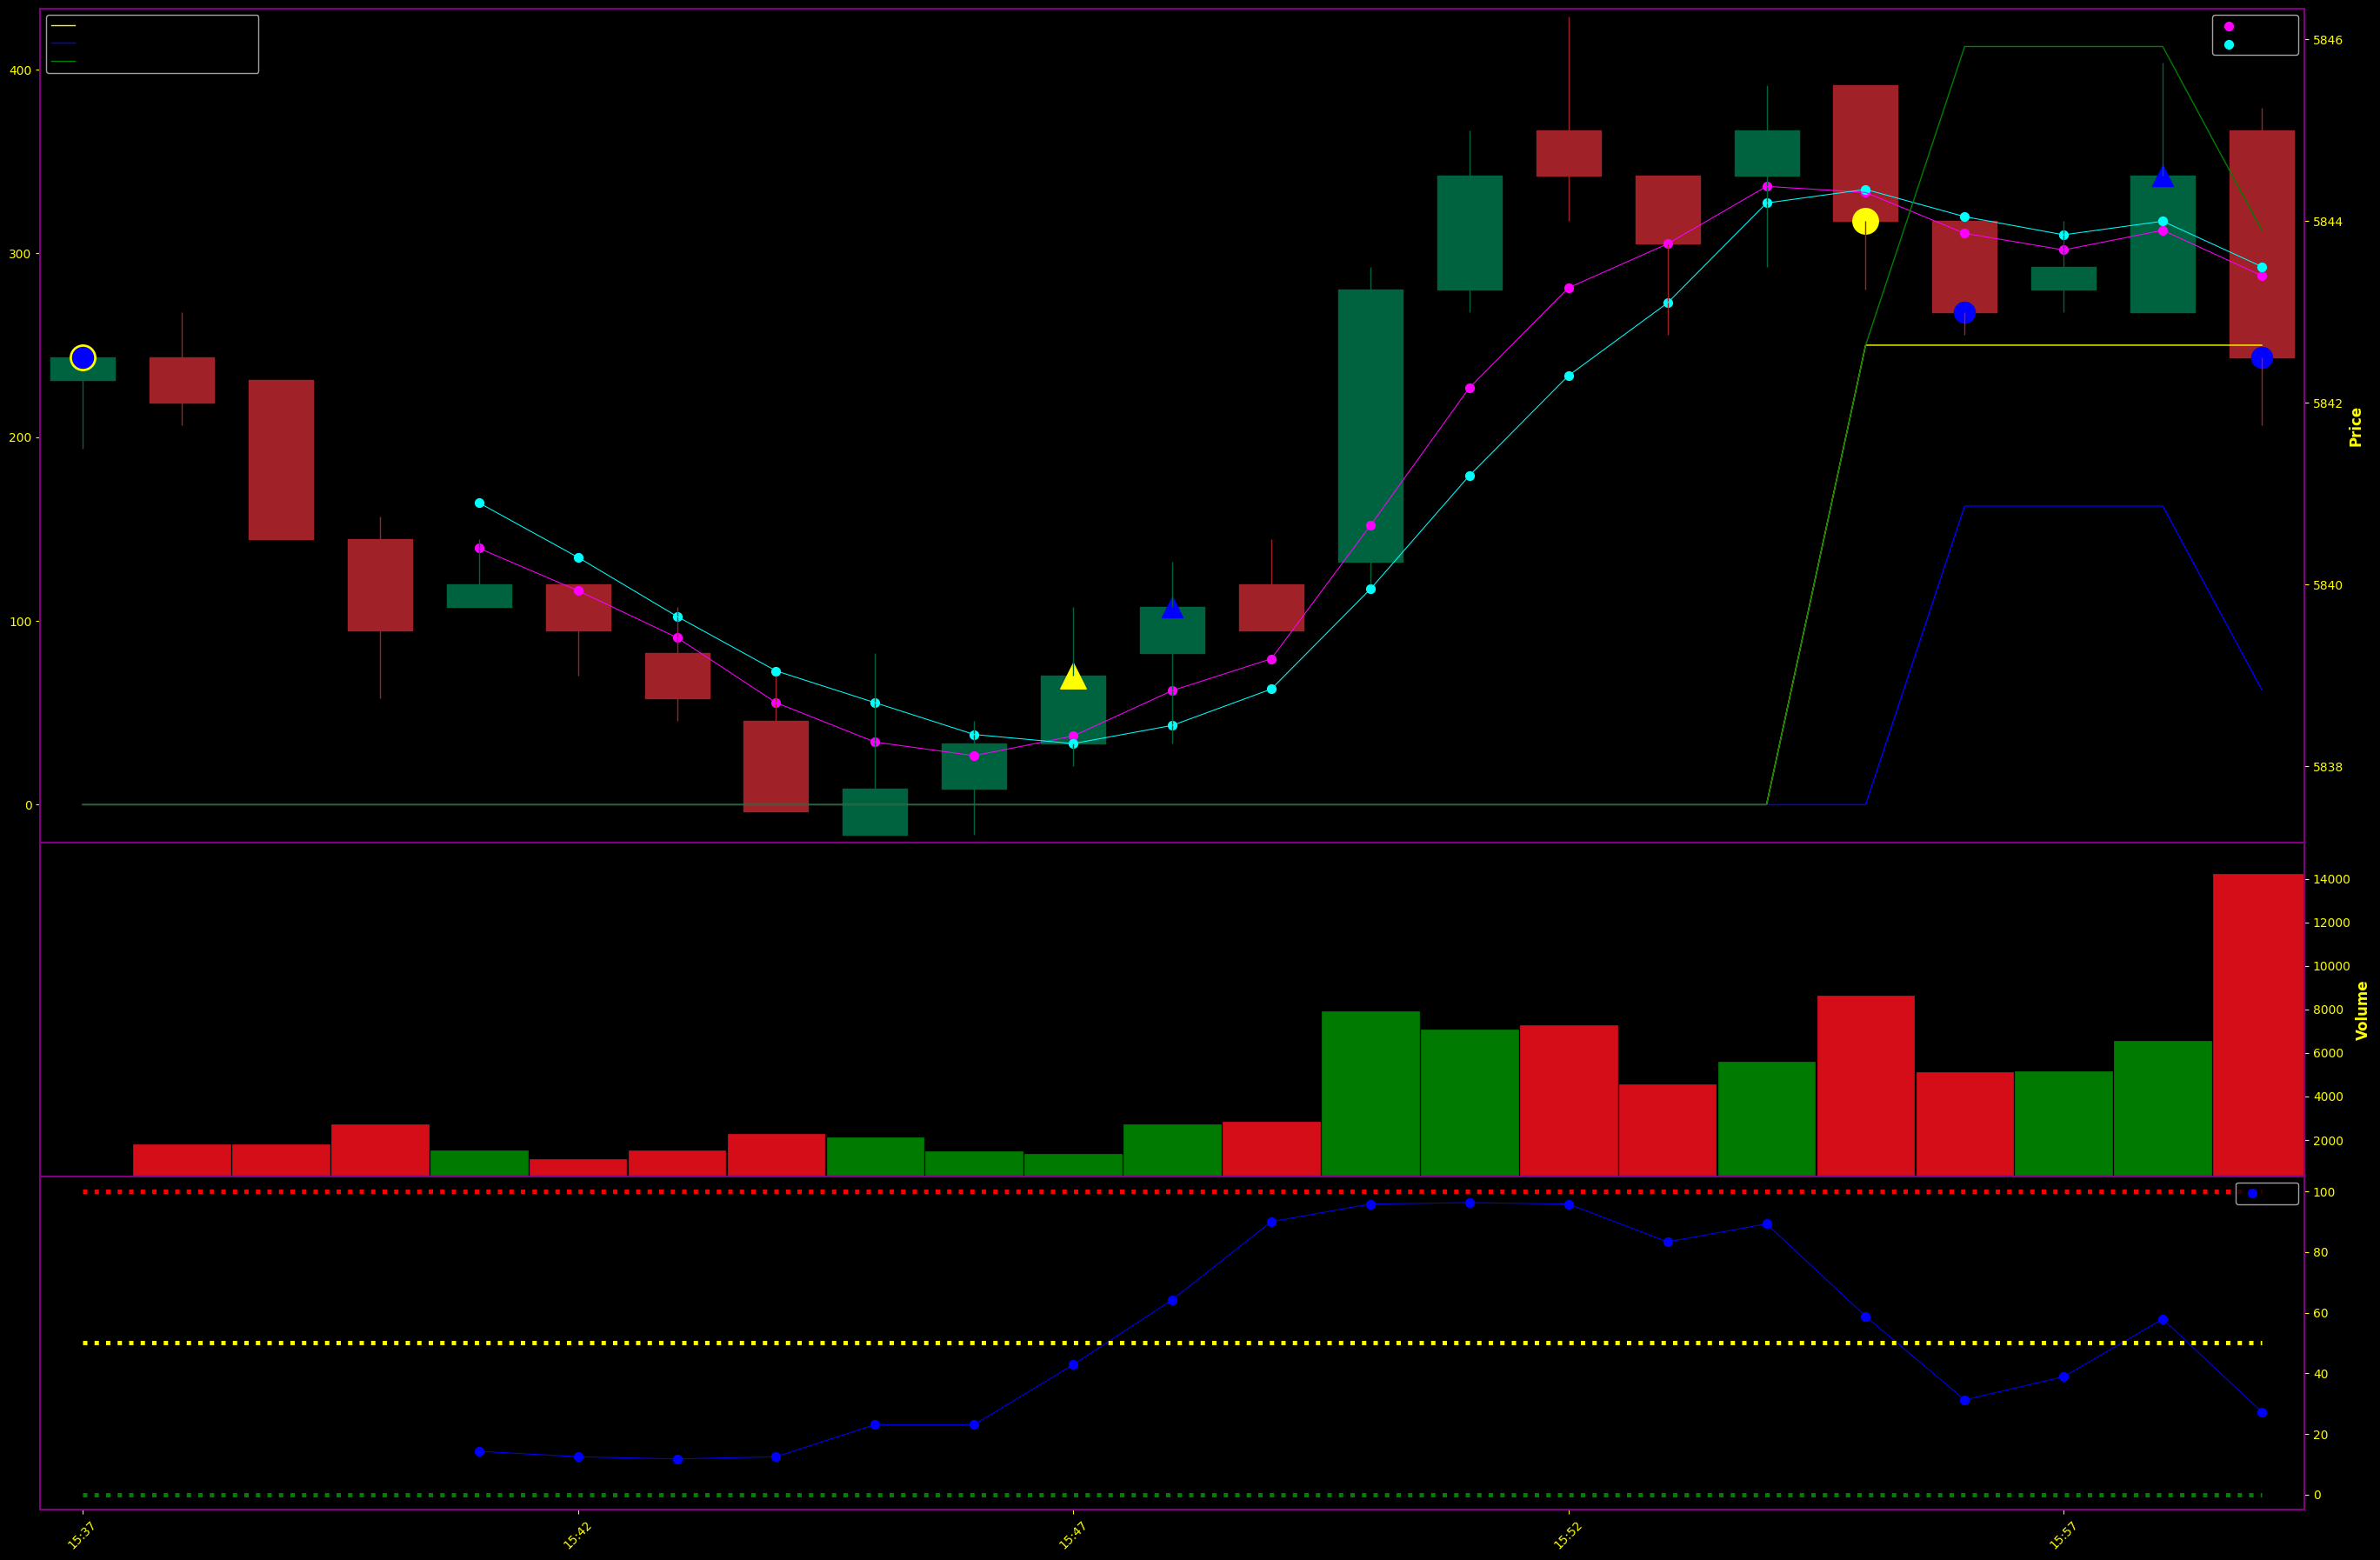

,datetime,ticker,open,high,low,close,accumulative_volume,volume,sma_5,sma_10,sma_20,wma_5,wma_10,wma_20,rsi_5,rsi_10,rsi_20,signal_wma_5_sma_5,signal_rsi_5,signal_wma_10_sma_10,signal_rsi_10,signal_wma_20_sma_20,signal_rsi_20,pnl_ma,pnl_rsi,hundred_line,fifty_line,zero_line,cum_pnl_ma,cum_pnl_rsi,cum_pnl_all,buy_marker,sell_marker,neutral_marker,buy_marker_2,sell_marker_2,neutral_marker_2
0,2024-10-09 15:37:00-04:00,/ES,"5,842.2500","5,842.5000","5,841.5000","5,842.5000",874747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,"5,842.5000",None,None,"5,842.5000"
1,2024-10-09 15:38:00-04:00,/ES,"5,842.5000","5,843.0000","5,841.7500","5,842.0000",876549,"1,802.0000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
2,2024-10-09 15:39:00-04:00,/ES,"5,842.2500","5,842.2500","5,840.5000","5,840.5000",878332,"1,783.0000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
3,2024-10-09 15:40:00-04:00,/ES,"5,840.5000","5,840.7500","5,838.7500","5,839.5000",881028,"2,696.0000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
4,2024-10-09 15:41:00-04:00,/ES,"5,839.7500","5,840.5000","5,839.7500","5,840.0000",882551,"1,523.0000","5,840.9000",NaN,NaN,"5,840.4000",NaN,NaN,14.2857,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
5,2024-10-09 15:42:00-04:00,/ES,"5,840.0000","5,840.0000","5,839.0000","5,839.5000",883654,"1,103.0000","5,840.3000",NaN,NaN,"5,839.9333",NaN,NaN,12.5000,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
6,2024-10-09 15:43:00-04:00,/ES,"5,839.2500","5,839.7500","5,838.5000","5,838.7500",885153,"1,499.0000","5,839.6500",NaN,NaN,"5,839.4167",NaN,NaN,11.7647,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
7,2024-10-09 15:44:00-04:00,/ES,"5,838.5000","5,839.0000","5,837.5000","5,837.5000",887408,"2,255.0000","5,839.0500",NaN,NaN,"5,838.7000",NaN,NaN,12.5000,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
8,2024-10-09 15:45:00-04:00,/ES,"5,837.2500","5,839.2500","5,837.2500","5,837.7500",889517,"2,109.0000","5,838.7000",NaN,NaN,"5,838.2667",NaN,NaN,23.0769,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
9,2024-10-09 15:46:00-04:00,/ES,"5,837.7500","5,838.5000","5,837.2500","5,838.2500",890987,"1,470.0000","5,838.3500","5,839.6250",NaN,"5,838.1167","5,838.8455",NaN,23.0769,18.5185,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None


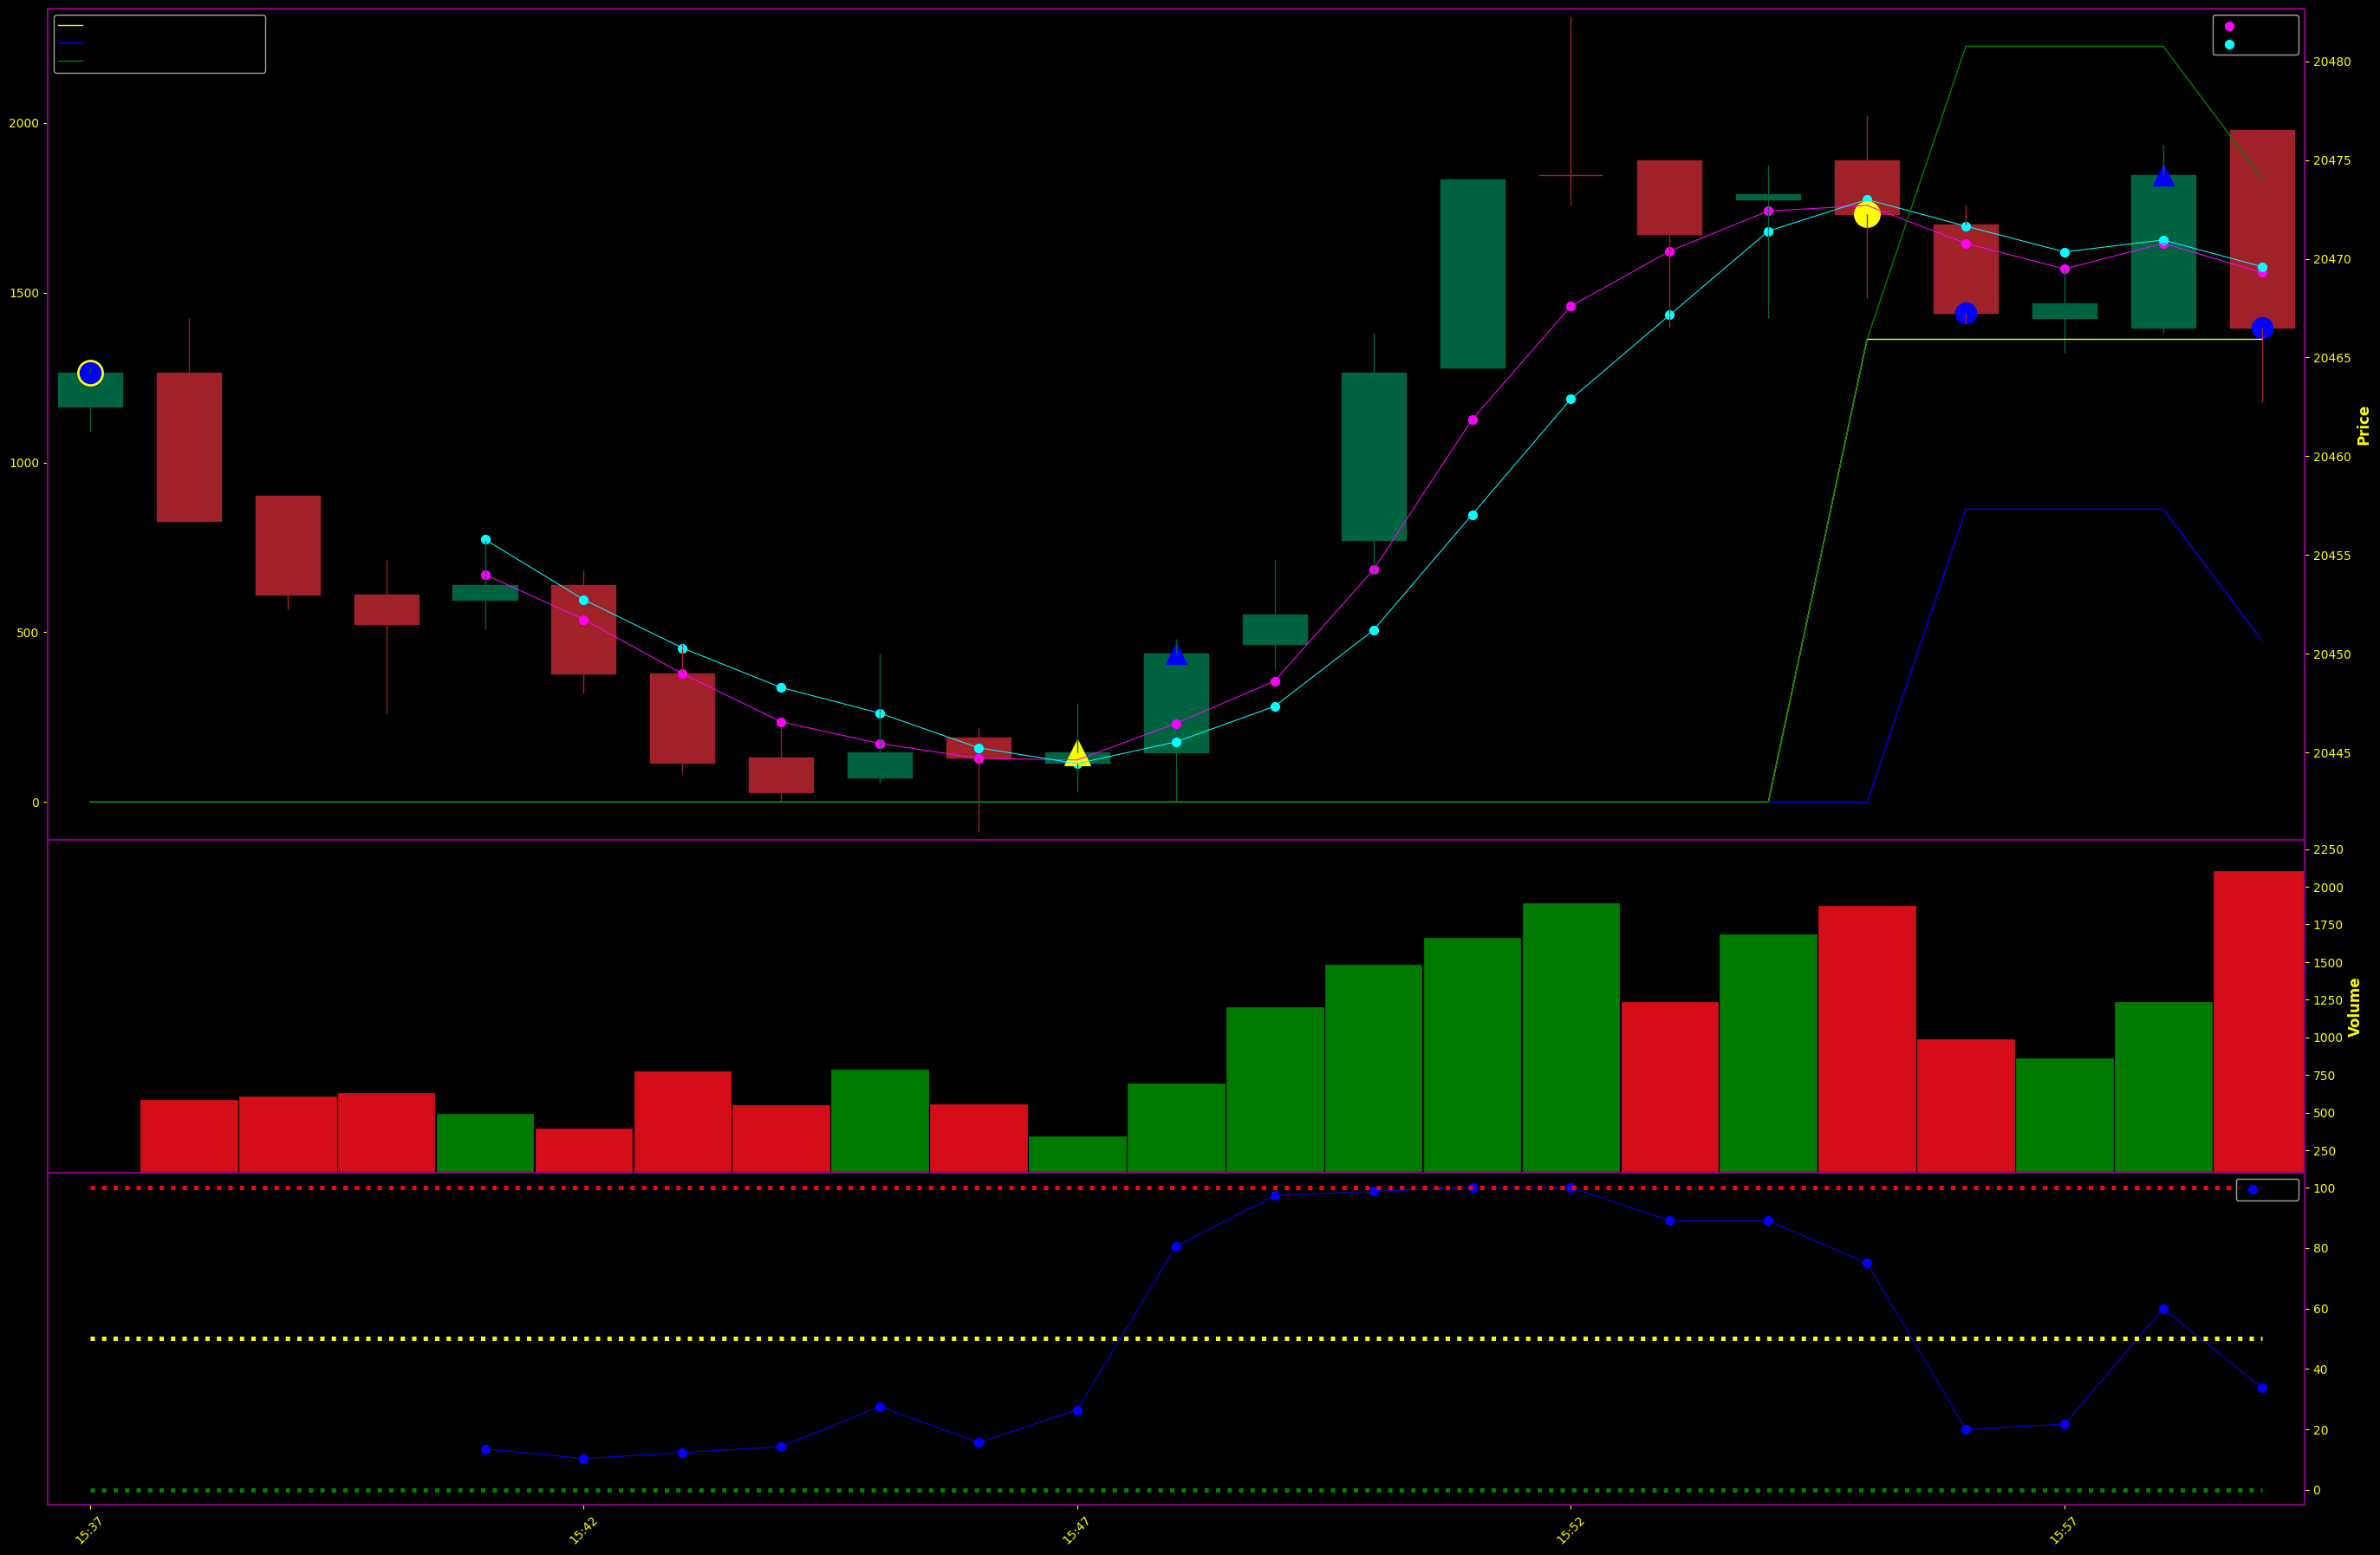

,datetime,ticker,open,high,low,close,accumulative_volume,volume,sma_5,sma_10,sma_20,wma_5,wma_10,wma_20,rsi_5,rsi_10,rsi_20,signal_wma_5_sma_5,signal_rsi_5,signal_wma_10_sma_10,signal_rsi_10,signal_wma_20_sma_20,signal_rsi_20,pnl_ma,pnl_rsi,hundred_line,fifty_line,zero_line,cum_pnl_ma,cum_pnl_rsi,cum_pnl_all,buy_marker,sell_marker,neutral_marker,buy_marker_2,sell_marker_2,neutral_marker_2
0,2024-10-09 15:37:00-04:00,/NQ,"20,462.5000","20,464.5000","20,461.2500","20,464.2500",373335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,"20,464.2500",None,None,"20,464.2500"
1,2024-10-09 15:38:00-04:00,/NQ,"20,464.2500","20,467.0000","20,456.7500","20,456.7500",373921,586.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
2,2024-10-09 15:39:00-04:00,/NQ,"20,458.0000","20,458.0000","20,452.2500","20,453.0000",374531,610.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
3,2024-10-09 15:40:00-04:00,/NQ,"20,453.0000","20,454.7500","20,447.0000","20,451.5000",375164,633.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
4,2024-10-09 15:41:00-04:00,/NQ,"20,452.7500","20,455.7500","20,451.2500","20,453.5000",375655,491.0000,"20,455.8000",NaN,NaN,"20,454.0167",NaN,NaN,13.5593,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
5,2024-10-09 15:42:00-04:00,/NQ,"20,453.5000","20,454.2500","20,448.0000","20,449.0000",376051,396.0000,"20,452.7500",NaN,NaN,"20,451.7500",NaN,NaN,10.3896,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
6,2024-10-09 15:43:00-04:00,/NQ,"20,449.0000","20,450.5000","20,444.0000","20,444.5000",376824,773.0000,"20,450.3000",NaN,NaN,"20,449.0000",NaN,NaN,12.3077,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
7,2024-10-09 15:44:00-04:00,/NQ,"20,444.7500","20,446.2500","20,442.5000","20,443.0000",377374,550.0000,"20,448.3000",NaN,NaN,"20,446.5667",NaN,NaN,14.2857,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
8,2024-10-09 15:45:00-04:00,/NQ,"20,443.7500","20,450.0000","20,443.5000","20,445.0000",378161,787.0000,"20,447.0000",NaN,NaN,"20,445.4667",NaN,NaN,27.5862,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None
9,2024-10-09 15:46:00-04:00,/NQ,"20,445.7500","20,446.2500","20,441.0000","20,444.7500",378719,558.0000,"20,445.2500","20,450.5250",NaN,"20,444.7167","20,447.4955",NaN,15.6863,14.5455,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100,50,0,0.0000,0.0000,0.0000,None,None,None,None,None,None


In [31]:
sig_ma = 'wma_5'
con_ma = 'sma_5'
rsi_plt = 'rsi_5'
signal_ma='signal_wma_5_sma_5'
signal_rsi='signal_rsi_5'

visualize_trades()

In [ ]:
sig_ma = 'wma_10'
con_ma = 'sma_10'
rsi_plt = 'rsi_10'
signal_ma='signal_wma_10_sma_10'
signal_rsi='signal_rsi_10'

visualize_trades()

In [ ]:
sig_ma = 'wma_20'
con_ma = 'sma_20'
rsi_plt = 'rsi_20'
signal_ma='signal_wma_20_sma_20'
signal_rsi='signal_rsi_20'

visualize_trades()

Write data to csv

In [31]:
def write_to_csv(df, filename):
    # Check if the file exists
    file_exists = os.path.isfile(filename)
    
    # Write to CSV; if file exists, append without writing the header
    df.to_csv(filename, mode='a' if file_exists else 'w', header=not file_exists, index=False)

In [ ]:
# Example usage
filename = f'minute_candles_ES.csv'
# filename = f'minute_candles_MARA.csv'
write_to_csv(minute_candles, filename)

In [ ]:
# warnings.simplefilter(action='default', category=FutureWarning)

# Creating a dictionary containing order details.

This will get the hashValue of the first linked account.

In [ ]:
linked_accounts = client.account_linked().json()
linked_accounts

Get account number and hashes for linked accounts.

In [ ]:
account_hash = linked_accounts[0].get('hashValue')
print(account_hash)
# sleep(3)

In [31]:
buy_order = {"orderType": "MARKET",
        "session": "NORMAL",
        "duration": "DAY",
        "orderStrategyType": "SINGLE",
        "orderLegCollection": [
            {
                "instruction": "BUY",
                "quantity": 1,
                "instrument": {
                    "symbol": "ENVX",
                    "assetType": "EQUITY"
                }
            }
            ]
        }  

In [ ]:
# client.order_place(account_hash, buy_order)

Placing the order created above.

In [ ]:
# resp = client.order_place(account_hash, order)
# print(f"Response code: {resp}")

Get the order ID. If the order is immediately filled, its id might not be returned.

In [ ]:
# order_id = resp.headers.get('location', '/').split('/')[-1] 
# print(f"Order id: {order_id}")

Get specific order details

In [ ]:
# client.order_details(account_hash, order_id).json()

Cancel specific order.

In [ ]:
# print(client.order_cancel(account_hash, order_id))

In [ ]:
{
  "session": "NORMAL",                             # Indicates that the trading session is the normal market session
  "duration": "DAY",                               # Specifies that the order is valid only for the trading day
  "orderType": "MARKET",                           # Sets the order type to 'MARKET', meaning it will be executed at the current market price
  "cancelTime": "2024-09-17T02:32:09.008Z",        # Time when the order will be canceled if not executed
  "complexOrderStrategyType": "NONE",              # No complex order strategy is applied
  "quantity": 0,                                   # Number of shares/contracts to be ordered (0 in this case, placeholder)
  "filledQuantity": 0,                             # Number of shares/contracts that have been filled (none in this case)
  "remainingQuantity": 0,                          # Number of shares/contracts remaining to be filled (none in this case)
  "destinationLinkName": "string",                 # Placeholder for the routing destination of the order
  "releaseTime": "2024-09-17T02:32:09.008Z",       # Time when the order will be released for execution
  "stopPrice": 0,                                  # Stop price for stop orders (0 since it's not a stop order)
  "stopPriceLinkBasis": "MANUAL",                  # Manual basis for setting the stop price
  "stopPriceLinkType": "VALUE",                    # Stop price is set to a specific value
  "stopPriceOffset": 0,                            # Offset value for the stop price (0 since no offset is defined)
  "stopType": "STANDARD",                          # Type of stop order (STANDARD type is specified)
  "priceLinkBasis": "MANUAL",                      # Manual basis for setting the order price
  "priceLinkType": "VALUE",                        # Price is set to a specific value
  "price": 0,                                      # Price of the order (0 since this is a market order)
  "taxLotMethod": "FIFO",                          # First-In, First-Out (FIFO) method for calculating the tax lot
  "orderLegCollection": [                          # Collection of order legs, each representing a separate part of the order
    {
      "orderLegType": "EQUITY",                    # Indicates that this order leg is for an equity (stock)
      "legId": 0,                                  # Unique identifier for the order leg
      "instrument": {
        "cusip": "string",                         # CUSIP (placeholder) for identifying the instrument
        "symbol": "string",                        # Stock symbol (placeholder)
        "description": "string",                   # Description of the instrument (placeholder)
        "instrumentId": 0,                         # Unique instrument ID (placeholder)
        "netChange": 0,                            # Net price change of the instrument (0 for placeholder)
        "type": "SWEEP_VEHICLE"                    # Type of the instrument (sweep vehicle is used here)
      },
      "instruction": "BUY",                        # Instruction for the leg, in this case to 'BUY'
      "positionEffect": "OPENING",                 # Indicates that this order is opening a new position
      "quantity": 0,                               # Number of shares/contracts for this order leg (0 as placeholder)
      "quantityType": "ALL_SHARES",                # Specifies the quantity type for the order (all shares to be included)
      "divCapGains": "REINVEST",                   # Dividend or capital gains strategy, reinvest dividends
      "toSymbol": "string"                         # Placeholder for symbol conversion or destination
    }
  ],
  "activationPrice": 0,                            # Activation price for the order (not applicable here, so it's 0)
  "specialInstruction": "ALL_OR_NONE",             # Special instruction for the order, meaning it should execute fully or not at all
  "orderStrategyType": "SINGLE",                   # Single-order strategy (not part of a larger order strategy)
  "orderId": 0,                                    # Unique identifier for the order (0 as a placeholder)
  "cancelable": false,                             # Indicates whether the order can be canceled (false here)
  "editable": false,                               # Indicates whether the order can be edited (false here)
  "status": "AWAITING_PARENT_ORDER",               # Status of the order (waiting for a parent order)
  "enteredTime": "2024-09-17T02:32:09.008Z",       # Time the order was entered
  "closeTime": "2024-09-17T02:32:09.008Z",         # Time the order was closed
  "accountNumber": 0,                              # Account number associated with the order (placeholder value)
  "orderActivityCollection": [                     # Collection of activities related to the order (e.g., executions)
    {
      "activityType": "EXECUTION",                 # Type of activity (execution of the order)
      "executionType": "FILL",                     # Execution type, indicating that the order has been filled
      "quantity": 0,                               # Number of shares/contracts executed (0 as placeholder)
      "orderRemainingQuantity": 0,                 # Remaining quantity of the order (0 since none is left)
      "executionLegs": [
        {
          "legId": 0,                              # ID for the execution leg
          "price": 0,                              # Price at which the order was executed
          "quantity": 0,                           # Quantity executed in this leg
          "mismarkedQuantity": 0,                  # Quantity marked incorrectly, if any
          "instrumentId": 0,                       # Instrument ID for this execution leg
          "time": "2024-09-17T02:32:09.008Z"       # Time of the execution leg
        }
      ]
    }
  ],
  "replacingOrderCollection": [                    # Collection of orders that are replacing this one (empty in this case)
    "string"
  ],
  "childOrderStrategies": [                        # Collection of child order strategies (empty in this case)
    "string"
  ],
  "statusDescription": "string"                    # Description of the current status of the order (placeholder)
}

{
  "session": "NORMAL",                             # The trading session. Can take values: "NORMAL", "AM", "PM", "SEAMLESS".
  "duration": "DAY",                               # Duration of the order. Can take values: "DAY", "GTC" (Good Till Canceled), "FOK" (Fill or Kill), "IOC" (Immediate or Cancel).
  "orderType": "MARKET",                           # Type of order. Can take values: "MARKET", "LIMIT", "STOP", "STOP_LIMIT".
  "cancelTime": "2024-09-17T02:32:09.008Z",        # Time when the order will be canceled if not executed. Format: ISO 8601.
  "complexOrderStrategyType": "NONE",              # Strategy type for complex orders. Can take values: "NONE", "COVERED", "VERTICAL", "CALENDAR", etc.
  "quantity": 0,                                   # Number of shares or contracts. Can be any positive integer.
  "filledQuantity": 0,                             # Number of shares/contracts filled. Can be any non-negative integer.
  "remainingQuantity": 0,                          # Number of shares/contracts remaining to be filled. Can be any non-negative integer.
  "destinationLinkName": "string",                 # Routing destination of the order. Can take values like "AUTO" (automatically routed) or specific exchanges.
  "releaseTime": "2024-09-17T02:32:09.008Z",       # Time the order will be released for execution. Format: ISO 8601.
  "stopPrice": 0,                                  # The price at which a stop order is triggered. Can be any non-negative number.
  "stopPriceLinkBasis": "MANUAL",                  # The basis for setting the stop price. Can take values: "MANUAL", "LAST", "BID", "ASK".
  "stopPriceLinkType": "VALUE",                    # The method used to link the stop price. Can take values: "VALUE", "PERCENT", "TICKS".
  "stopPriceOffset": 0,                            # Offset from the stop price. Can be any non-negative number.
  "stopType": "STANDARD",                          # Type of stop order. Can take values: "STANDARD", "TRAILING_STOP".
  "priceLinkBasis": "MANUAL",                      # Basis for the price of the order. Can take values: "MANUAL", "LAST", "BID", "ASK".
  "priceLinkType": "VALUE",                        # Method used to link the price. Can take values: "VALUE", "PERCENT", "TICKS".
  "price": 0,                                      # Order price (for limit orders). Can be any positive number.
  "taxLotMethod": "FIFO",                          # Tax lot method. Can take values: "FIFO", "LIFO", "HIFO", "SPECIFIC_LOT".
  "orderLegCollection": [                          # Collection of legs for multi-leg orders (e.g., options).
    {
      "orderLegType": "EQUITY",                    # Type of asset in the order leg. Can take values: "EQUITY", "OPTION", "FUTURE", "BOND".
      "legId": 0,                                  # Unique identifier for the leg. Can be any non-negative integer.
      "instrument": {
        "cusip": "string",                         # CUSIP number for the security. This is a unique 9-character identifier for securities.
        "symbol": "string",                        # Ticker symbol for the instrument (e.g., "AAPL").
        "description": "string",                   # Text description of the instrument (e.g., "Apple Inc.").
        "instrumentId": 0,                         # Unique identifier for the instrument. Can be any non-negative integer.
        "netChange": 0,                            # Net price change of the instrument. Can be any number (positive or negative).
        "type": "SWEEP_VEHICLE"                    # Type of instrument. Can take values: "EQUITY", "OPTION", "FUTURE", "SWEEP_VEHICLE".
      },
      "instruction": "BUY",                        # Instruction for this leg. Can take values: "BUY", "SELL", "BUY_TO_COVER", "SELL_SHORT".
      "positionEffect": "OPENING",                 # Indicates if the leg is opening or closing a position. Can take values: "OPENING", "CLOSING".
      "quantity": 0,                               # Number of shares/contracts in this leg. Can be any positive integer.
      "quantityType": "ALL_SHARES",                # Specifies the type of quantity. Can take values: "ALL_SHARES", "DOLLARS".
      "divCapGains": "REINVEST",                   # Dividend/capital gains instructions. Can take values: "REINVEST", "CASH".
      "toSymbol": "string"                         # Conversion symbol, if applicable (e.g., stock split).
    }
  ],
  "activationPrice": 0,                            # Price at which the order becomes active (for stop orders). Can be any positive number.
  "specialInstruction": "ALL_OR_NONE",             # Special instruction for the order. Can take values: "ALL_OR_NONE", "NONE", "DO_NOT_REDUCE".
  "orderStrategyType": "SINGLE",                   # Strategy type for the order. Can take values: "SINGLE", "OCO" (One Cancels Other), "OTO" (One Triggers Other).
  "orderId": 0,                                    # Unique identifier for the order. Can be any non-negative integer.
  "cancelable": false,                             # Indicates whether the order can be canceled. Boolean: true/false.
  "editable": false,                               # Indicates whether the order can be edited. Boolean: true/false.
  "status": "AWAITING_PARENT_ORDER",               # Status of the order. Can take values: "AWAITING_PARENT_ORDER", "FILLED", "CANCELED", etc.
  "enteredTime": "2024-09-17T02:32:09.008Z",       # Time when the order was entered. Format: ISO 8601.
  "closeTime": "2024-09-17T02:32:09.008Z",         # Time when the order was closed (if applicable). Format: ISO 8601.
  "accountNumber": 0,                              # Account number associated with the order. Can be any valid account number.
  "orderActivityCollection": [                     # Collection of activities related to the order (e.g., executions).
    {
      "activityType": "EXECUTION",                 # Type of activity. Can take values: "EXECUTION", "CANCEL", etc.
      "executionType": "FILL",                     # Execution type, meaning the order was filled. Can also be "PARTIAL_FILL".
      "quantity": 0,                               # Quantity executed. Can be any positive integer.
      "orderRemainingQuantity": 0,                 # Remaining quantity after this execution. Can be any positive integer.
      "executionLegs": [
        {
          "legId": 0,                              # ID of the execution leg. Can be any non-negative integer.
          "price": 0,                              # Price at which the execution took place. Can be any positive number.
          "quantity": 0,                           # Quantity executed in this leg. Can be any positive integer.
          "mismarkedQuantity": 0,                  # Quantity that was incorrectly marked (if applicable). Can be any positive integer.
          "instrumentId": 0,                       # Unique identifier for the instrument executed. Can be any non-negative integer.
          "time": "2024-09-17T02:32:09.008Z"       # Time the execution occurred. Format: ISO 8601.
        }
      ]
    }
  ],
  "replacingOrderCollection": [                    # Collection of orders that are replacing this one (if applicable). Empty in this case.
    "string"
  ],
  "childOrderStrategies": [                        # Collection of child order strategies (if applicable). Empty in this case.
    "string"
  ],
  "statusDescription": "string"                    # Description of the current order status. Text string.
}

